# EYE FOR BLIND

### Overview:
This project aims to develop a deep learning model to verbally describe image contents for the visually impaired using caption generation with an attention mechanism on the Flickr8K dataset. 

Inspired by the "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention" paper, the model utilizes a CNN-RNN architecture to extract image features and generate captions, facilitating accessibility. 

The Kaggle dataset comprises 8,000 images, each paired with five descriptive captions, enabling comprehensive understanding of image content.

In [19]:
!pip install gTTS

In [20]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from tqdm import tqdm
import time
from IPython import display

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from gtts import gTTS

import warnings
warnings.filterwarnings('ignore')

# Data understanding
1. Importing the dataset and read image & captions into two seperate variables

2. Visualising both the images & text present in the dataset

3. Creating a dataframe which summarizes the image, path & captions as a dataframe

4. Creating a list which contains all the captions & path

5. Visualising the top 30 occuring words in the captions

### Importing the dataset and reading image & captions into two seperate variables

In [21]:
images= '/kaggle/input/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


### Visualising the image & text present in the dataset

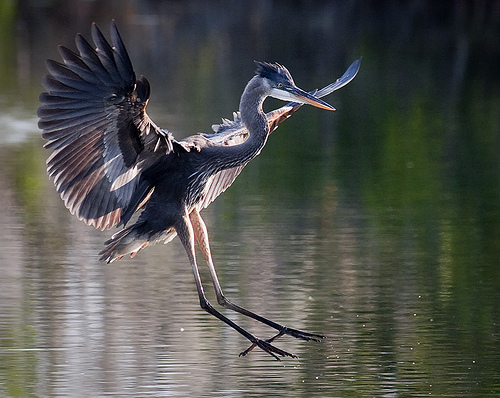

In [22]:
Image.open(all_imgs[4321])

In [23]:
def load_doc(filename):
    with open(filename) as f:
        text = f.read()
    return text

text_file = '/kaggle/input/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


### Creating a dataframe which summarizes the image, path & captions as a dataframe



Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [24]:
all_img_id= []
all_img_vector= []
annotations= []

file = doc.splitlines()[1:]
for line in file:
    split=line.index(",")
    ids = line[:split]
    caption = line[split+1:]
    all_img_id.append(ids)
    annotations.append(caption)
    all_img_vector.append('/kaggle/input/Images/'+ids)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

ID                                            Path  \
0  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [25]:
#Creating the vocabulary & the counter for the captions

vocabulary = [word.lower() for line in annotations for word in line.split()]

val_count = Counter(vocabulary)
val_count.most_common(10)

[('a', 61752),
 ('.', 34212),
 ('in', 18965),
 ('the', 18249),
 ('on', 10732),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8126),
 ('with', 7761),
 ('man', 7238)]

### Visualising the top 30 occuring words in the captions

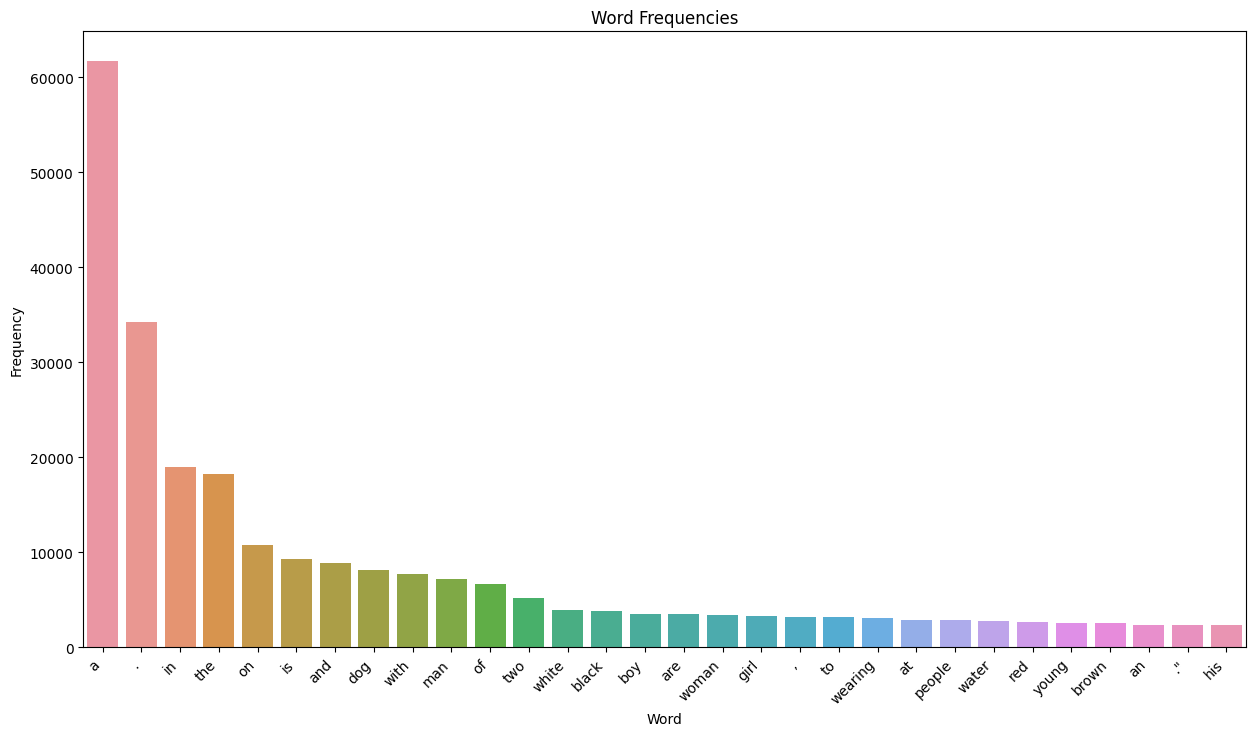

In [26]:
temp_df = pd.DataFrame(val_count.most_common(30), columns = ['Word', 'Frequency'])
plt.figure(figsize=(15,8))
sns.barplot(x='Word', y='Frequency', data=temp_df)
plt.title('Word Frequencies')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [27]:
#Creating a list that will contain all the captions
annotations = df.Captions.map(lambda x : '<start> '+x+' <end>').to_list()

#list that contains all the path to the images
all_img_path = df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


# Pre-Processing the captions
1. Creating the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Keeping the total vocaublary to top 5,000 words for saving memory.

2. Replacing all other words with the unknown token "UNK" .

3. Creating word-to-index and index-to-word mappings.

4. Pading all sequences to be the same length as the longest one.

In [28]:
# creating the tokenizer
top_word_count = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,oov_token= "<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [29]:
# Creating word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)

train_seqs = tokenizer.texts_to_sequences(annotations)

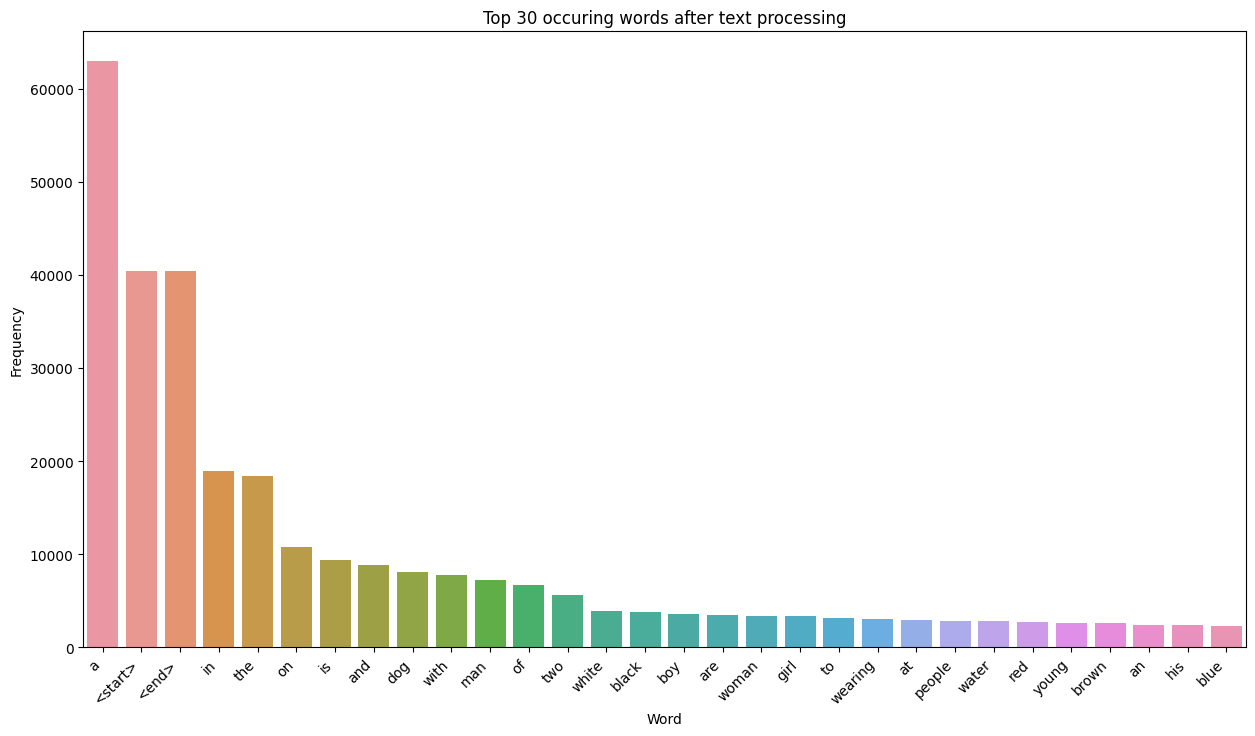

In [30]:
# Creating a word count of the tokenizer to visulize the Top 30 occuring words after text processing

word_count_df = pd.DataFrame([tokenizer.word_counts]).T.reset_index()
word_count_df = word_count_df.sort_values(by=0,ascending=False).head(30).reset_index(drop=True).rename(columns={"index":"words",0:"counts"})

plt.figure(figsize=(15,8))
sns.barplot(x='words', y='counts', data=word_count_df)
plt.title('Top 30 occuring words after text processing')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [31]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_len = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_len)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


# Pre-processing the images

1. Resizing them into the shape of (299, 299)

2. Normalizing the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [32]:
def load_and_process_image(file_path, target_size=(299, 299)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.inception_v3.preprocess_input(img) # rest of the preprocessing is handle by this 
    
    return img, file_path

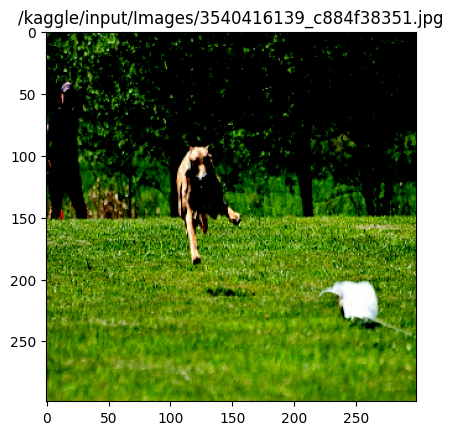

In [33]:
index = 2308

# Load and process the image using the function
processed_img, file_path = load_and_process_image(all_imgs[index])

# Display the processed image along with its file path
plt.imshow(processed_img)
plt.title(file_path)
plt.show()

In [34]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_and_process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
image_data_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

# Loading the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extracting the features of the images using the last layer of pre-trained model.

2.The shape of the output of this layer is 8x8x2048. 

3.Using a function to extract the features of each image in the train & test dataset such that the shape of each image is (batch_size, 8*8, 2048)

In [35]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 0s 0us/step


In [36]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [37]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [01:05<00:00,  3.84it/s]


In [38]:
batch_f.shape

TensorShape([64, 2048])

# Dataset creation
1. Applying train_test_split on both image path & captions to create the train & test list and creating the train-test split using 80-20 ratio & random state = 42

2. Creating a function which maps the image path to their feature. 

3. Builder function to create train & test dataset & apply the function created earlier to transform the dataset

In [39]:
path_train, path_test, cap_train, cap_test = train_test_split( all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [40]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [41]:
# This function will take the image_path & caption and return it's feature & respective caption.
def map_func(image_name,caption):
    img_tensor = feature_dict[image_name.decode('utf-8')]
    return img_tensor,caption

In [42]:
# Builder function to create dataset which takes in the image path & captions as input
# This function transforms the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [43]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [44]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


# Model Building
1. Setting the parameters

2. Building the Encoder, Attention model & Decoder

In [45]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_train) // BATCH_SIZE

### Encoder

In [46]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features)
        features =  tf.keras.activations.relu(features)
        
        return features

In [47]:
encoder=Encoder(embedding_dim)

### Attention model

In [48]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):

        hidden_with_time_axis = hidden[:, tf.newaxis]
        
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features

        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

### Decoder

In [49]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) 
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) 
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) 
        self.d2 = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) 
        embed = self.embed(x) 
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)
        output,state = self.gru(embed) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [50]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [51]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


# Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [52]:
optimizer = tf.keras.optimizers.Adam()  #optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, 
                                                            reduction = tf.keras.losses.Reduction.NONE) #loss object

In [53]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [54]:
#checkpoint path
checkpoint_path = "Flick8k/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [56]:
#training & testing step functions
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, avg_loss

In [57]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [58]:
#loss function for the test dataset
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [59]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.190, & test loss is 0.252
Time taken for 1 epoch 257.44141483306885 sec

Test loss has been reduced from 100.000 to 0.252


 10%|█         | 2/20 [06:03<50:28, 168.23s/it]  

For epoch: 2, the train loss is 0.936, & test loss is 0.223
Time taken for 1 epoch 105.47479295730591 sec

Test loss has been reduced from 0.252 to 0.223


 15%|█▌        | 3/20 [07:48<39:32, 139.59s/it]

For epoch: 3, the train loss is 0.851, & test loss is 0.206
Time taken for 1 epoch 105.33608818054199 sec

Test loss has been reduced from 0.223 to 0.206


 20%|██        | 4/20 [09:34<33:38, 126.17s/it]

For epoch: 4, the train loss is 0.790, & test loss is 0.192
Time taken for 1 epoch 105.45418381690979 sec

Test loss has been reduced from 0.206 to 0.192


 25%|██▌       | 5/20 [11:19<29:36, 118.45s/it]

For epoch: 5, the train loss is 0.741, & test loss is 0.181
Time taken for 1 epoch 104.59642958641052 sec

Test loss has been reduced from 0.192 to 0.181


 30%|███       | 6/20 [13:04<26:33, 113.85s/it]

For epoch: 6, the train loss is 0.696, & test loss is 0.170
Time taken for 1 epoch 104.77190923690796 sec

Test loss has been reduced from 0.181 to 0.170


 35%|███▌      | 7/20 [14:48<24:01, 110.86s/it]

For epoch: 7, the train loss is 0.657, & test loss is 0.160
Time taken for 1 epoch 104.51928424835205 sec

Test loss has been reduced from 0.170 to 0.160


 40%|████      | 8/20 [16:33<21:48, 109.05s/it]

For epoch: 8, the train loss is 0.621, & test loss is 0.152
Time taken for 1 epoch 105.0023250579834 sec

Test loss has been reduced from 0.160 to 0.152


 45%|████▌     | 9/20 [18:19<19:47, 107.93s/it]

For epoch: 9, the train loss is 0.587, & test loss is 0.144
Time taken for 1 epoch 105.2946629524231 sec

Test loss has been reduced from 0.152 to 0.144


 50%|█████     | 10/20 [20:04<17:49, 106.94s/it]

For epoch: 10, the train loss is 0.558, & test loss is 0.136
Time taken for 1 epoch 104.56849932670593 sec

Test loss has been reduced from 0.144 to 0.136


 55%|█████▌    | 11/20 [21:48<15:56, 106.28s/it]

For epoch: 11, the train loss is 0.529, & test loss is 0.130
Time taken for 1 epoch 104.60481810569763 sec

Test loss has been reduced from 0.136 to 0.130


 60%|██████    | 12/20 [23:33<14:06, 105.83s/it]

For epoch: 12, the train loss is 0.504, & test loss is 0.124
Time taken for 1 epoch 104.64494800567627 sec

Test loss has been reduced from 0.130 to 0.124


 65%|██████▌   | 13/20 [25:18<12:18, 105.51s/it]

For epoch: 13, the train loss is 0.481, & test loss is 0.118
Time taken for 1 epoch 104.59038615226746 sec

Test loss has been reduced from 0.124 to 0.118


 70%|███████   | 14/20 [27:03<10:31, 105.21s/it]

For epoch: 14, the train loss is 0.461, & test loss is 0.113
Time taken for 1 epoch 104.33342266082764 sec

Test loss has been reduced from 0.118 to 0.113


 75%|███████▌  | 15/20 [28:47<08:45, 105.07s/it]

For epoch: 15, the train loss is 0.442, & test loss is 0.110
Time taken for 1 epoch 104.58534860610962 sec

Test loss has been reduced from 0.113 to 0.110


 80%|████████  | 16/20 [30:32<07:00, 105.10s/it]

For epoch: 16, the train loss is 0.425, & test loss is 0.105
Time taken for 1 epoch 105.0099310874939 sec

Test loss has been reduced from 0.110 to 0.105


 85%|████████▌ | 17/20 [32:17<05:14, 104.99s/it]

For epoch: 17, the train loss is 0.409, & test loss is 0.101
Time taken for 1 epoch 104.56682515144348 sec

Test loss has been reduced from 0.105 to 0.101


 90%|█████████ | 18/20 [34:02<03:29, 104.93s/it]

For epoch: 18, the train loss is 0.394, & test loss is 0.098
Time taken for 1 epoch 104.60841274261475 sec

Test loss has been reduced from 0.101 to 0.098


 95%|█████████▌| 19/20 [35:47<01:44, 104.85s/it]

For epoch: 19, the train loss is 0.382, & test loss is 0.095
Time taken for 1 epoch 104.47296380996704 sec

Test loss has been reduced from 0.098 to 0.095


100%|██████████| 20/20 [37:32<00:00, 112.61s/it]

For epoch: 20, the train loss is 0.370, & test loss is 0.092
Time taken for 1 epoch 104.90755128860474 sec

Test loss has been reduced from 0.095 to 0.092


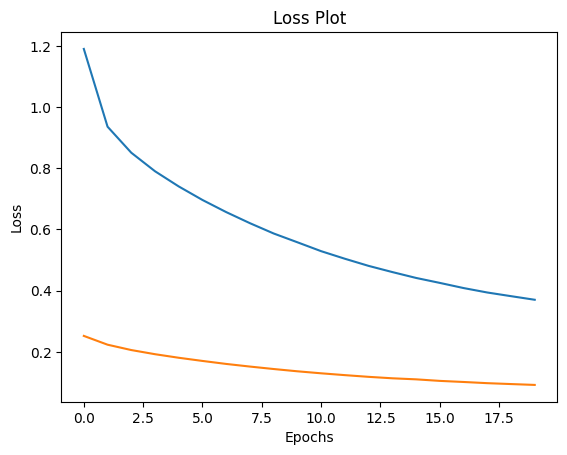

In [60]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Greedy Search

In [61]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [62]:
def evaluate(image):
    max_length = 39
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_and_process_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

In [63]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [64]:
from nltk.translate.bleu_score import sentence_bleu

In [65]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [79]:
def testing(weights=(0.25,0.25,0.25,0.25), image_number = 0):
    if image_number:
        rid = image_number
    else:
        rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    pred_caption = pred_caption.replace('<unk>','')
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights= weights) #set your weights
    print(rid)
    print(f"BELU score: {score*100}")

    print('Real Caption:', real_caption)
    print('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #TTS
    myobj = gTTS(text=pred_caption, lang='en', slow=False)

    audio_file_name = "text_to_speech.mp3"

    myobj.save(audio_file_name)

    display.display(display.Audio(audio_file_name, rate=None,autoplay=False))

    return(test_image)

4287
BELU score: 21.938936848339242
Real Caption: a football player runs across the field as the referee blows his whistle
Prediction Caption: a football player running on the field


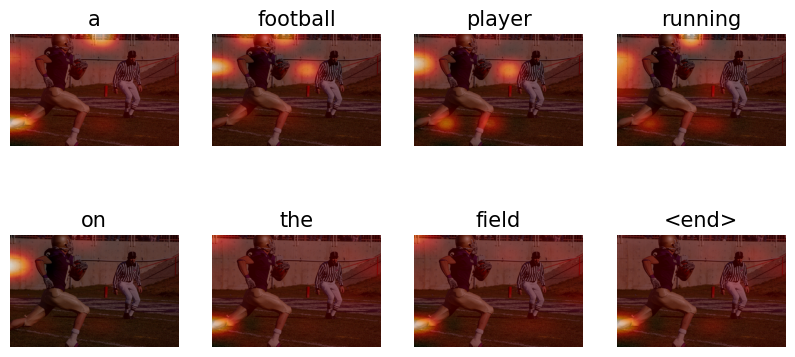

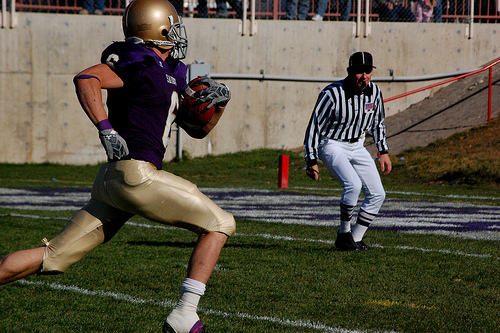

In [80]:
test_image = testing()
Image.open(test_image)

660
BELU score: 16.90308509457033
Real Caption: two young boys are wrestling in a sand pit
Prediction Caption: two boys one in a blue shirt are playing in the sand at a park


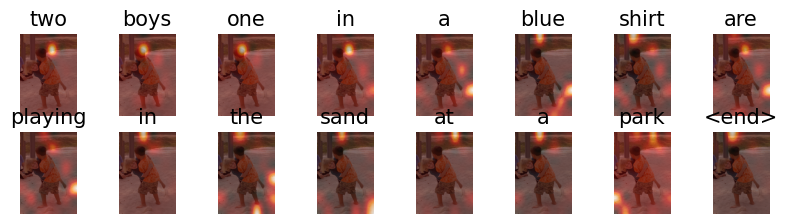

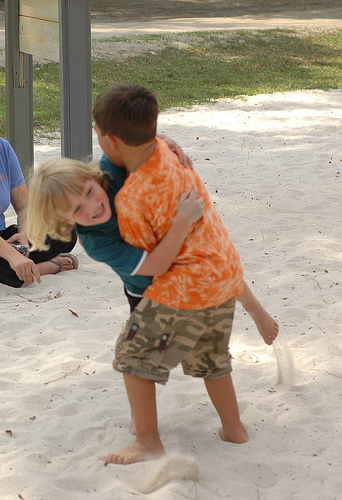

In [81]:
test_image = testing(weights=(0.5,0.5,0.5,0.5))
Image.open(test_image)

1612
BELU score: 17.978662999019786
Real Caption: a woman wearing a cap on a wintry street
Prediction Caption: a woman wearing a long black jacket is on a wintry street


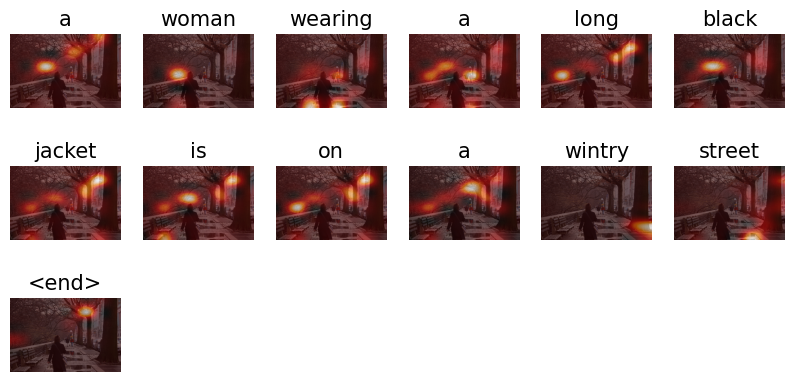

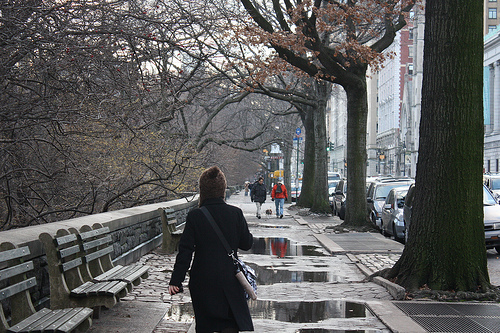

In [82]:
test_image = testing(weights=(0.5,0.5,0.5,0.5))
Image.open(test_image)

3820
BELU score: 13.435589949660812
Real Caption: a dog leaps off a dock and into the water
Prediction Caption: a black dog is jumping into the water


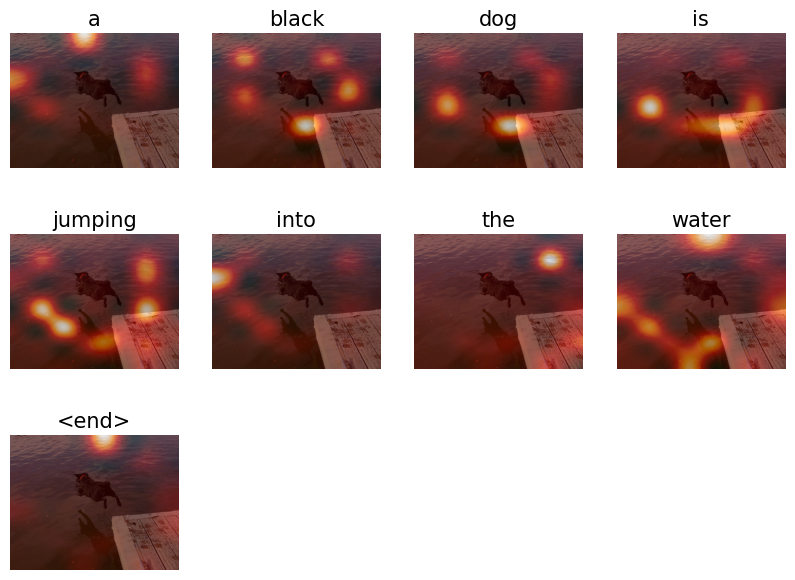

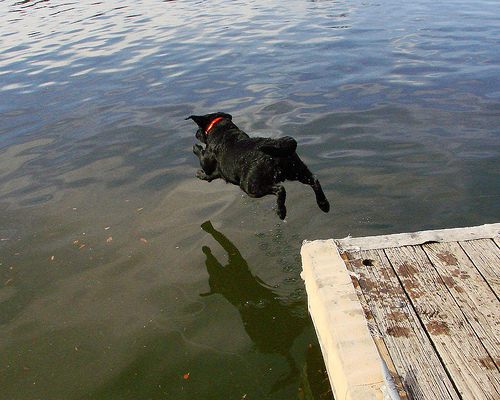

In [95]:
test_image = testing(weights=(0.5, 0.5 , 0.5, 0.5))
Image.open(test_image)

134
BELU score: 15.163266492815836
Real Caption: two women the younger one is looking down the older is drinking
Prediction Caption: two women one looking down the other drinking


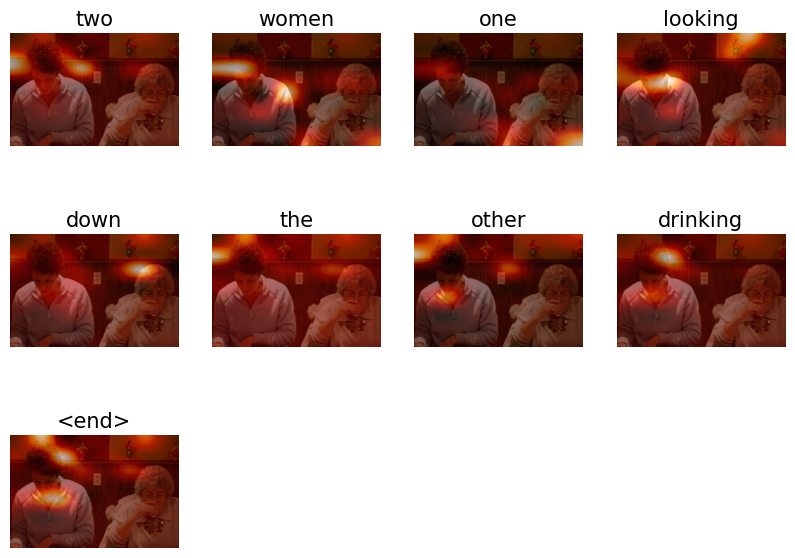

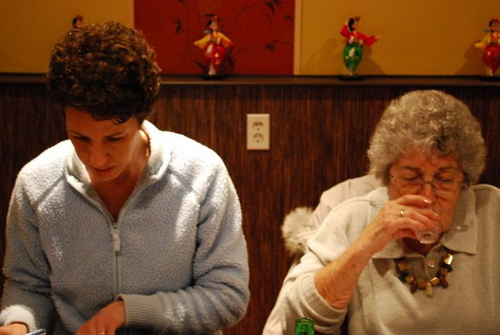

In [84]:
test_image = testing(weights=(0.5, 0.5 , 0.5, 0.5))
Image.open(test_image)

5187
BELU score: 2.874457732434855
Real Caption: a dancer in a dancing pose on the street audience in the
Prediction Caption: a woman dances


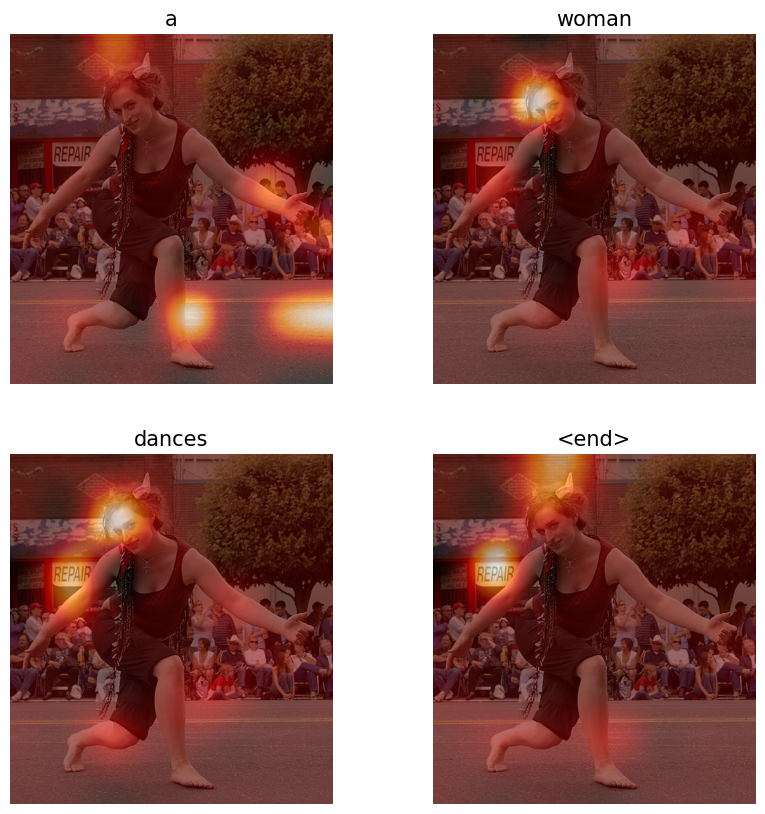

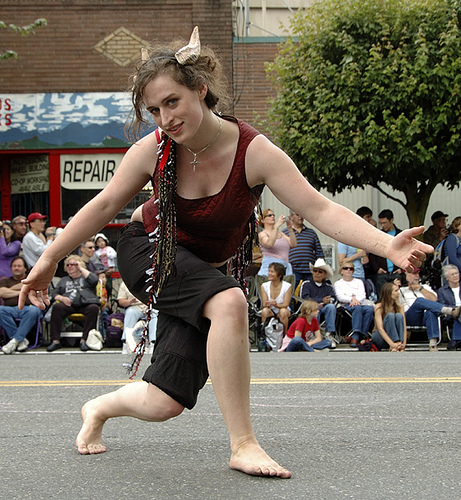

In [89]:
test_image = testing(weights=(0.5, 0.25 , 0.25, 0))
Image.open(test_image)

3666
BELU score: 52.70462766947299
Real Caption: a furry tan dog is outside on a patio
Prediction Caption: a furry dog is running down a wooden floor


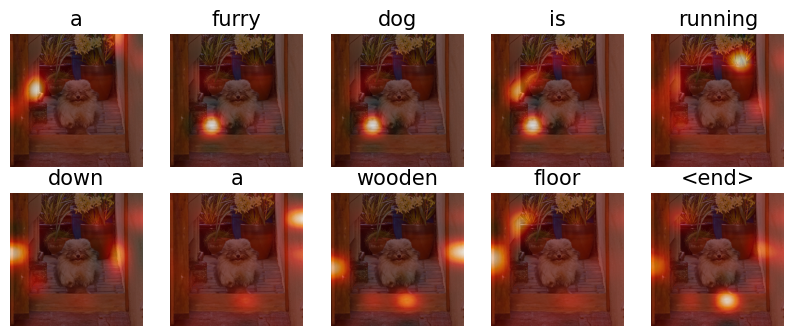

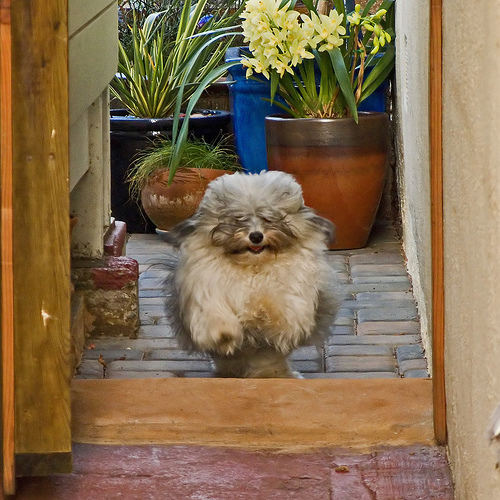

In [90]:
test_image = testing(weights=(0.5, 0.25 , 0.25, 0.25))
Image.open(test_image)

# Conclusion

- We limited the training to 20 epochs only, as the primary goal was not to build a state-of-the-art model but rather to explore the integration of the attention mechanism with the Encoder-Decoder architecture for image processing.

- To check how well our model was doing, we used the BLUE Score, a measure of caption quality. Testing different combinations of weights, our model consistently scored the maximum Bleu Score (100%), proving its reliability in various setups.

- Caption predictions were made by calculating the likelihood of each word in our vocabulary. Using Greedy Search, we picked the word with the highest likelihood, ensuring our captions made sense.